In [2]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from astropy.io import fits
from astropy.utils.data import download_file

import sys
import os
import cv2
sys.path.append(os.path.join('C:/', 'Users', 'ASUS', 'Documents', 'GitHub', 'satmetrics'))
import line_detection_updated as ld
from photutils.background import Background2D

import image_rotation as ir


In [3]:
import pixelplot

In [4]:
def load_decam_image(expnum, detector):
    """
   Load a  DECam image given the exposure number (expnum) and detector number (HDU).
    """
    natroot = 'https://astroarchive.noirlab.edu'
    adsurl = f'{natroot}/api/adv_search'

    jj = {
        "outfields": ["md5sum", "archive_filename", "EXPNUM"],
        "search": [
            ["instrument", "decam"],
            ["proc_type", "instcal"],
            ["EXPNUM", expnum, expnum],
            ["prod_type", "image"],
        ]
    }

    apiurl = f'{adsurl}/find/?limit=1'
    data = requests.post(apiurl, json=jj).json()

    if len(data) < 2:
        raise ValueError(f"No se encontró ninguna imagen para expnum {expnum}")

    query_result = data[1]
    md5sum = query_result['md5sum']

    access_url = f'{natroot}/api/retrieve/{md5sum}/?hdus={detector}'
    filename = download_file(access_url, cache=True)

    hdu_list = fits.open(filename)
    image = hdu_list[1].data
    header = hdu_list[1].header

    header_expnum = hdu_list[0].header

    return image, header, header_expnum


In [5]:
def plot_decam_image(image, expnum=None, detector=None):
    """
    Displays a DECam image using matplotlib, with some basic contrast scaling 
    and optional labels for exposure number and detector.
    """
    # Compute contrast limits using percentiles
    vmin = np.percentile(image, 5)
    vmax = np.percentile(image, 95)

    # Transpose for better visual orientation
    img = np.flip(image.T)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    
    title = "DECam Image"
    if expnum is not None and detector is not None:
        title += f" — expnum {expnum}, detector {detector}"
    elif expnum is not None:
        title += f" — expnum {expnum}"
    elif detector is not None:
        title += f" — detector {detector}"
    
    plt.title(title, fontsize=14)
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [6]:

#def detect_lines_hough(image, threshold=0.075, **kwargs):
def detect_lines_hough(image, threshold=0.075, flux_prop_thresholds=[0.1,0.2,0.3,1], 
                       blur_kernel_sizes=[3,5,9,11], brightness_cuts=(2,2), thresholding_cut=0.5 ,**kwargs):

    """
    Applies Hough Transform line detection on a DECam image using the custom satmetrics module.

    Parameters:
        image (ndarray): 2D image array.
        **kwargs: Optional keyword arguments to pass into the LineDetection object (e.g. thresholds).
    """
    lineDetector = ld.LineDetection(image)
    lineDetector.threshold = threshold
    lineDetector.flux_prop_thresholds = flux_prop_thresholds
    lineDetector.blur_kernel_sizes = blur_kernel_sizes
    lineDetector.brightness_cuts = brightness_cuts
    lineDetector.thresholding_cut = thresholding_cut
    # Detector instance
   # lineDetector = ld.LineDetection(image)
    #lineDetector.threshold = 0.012 it could break the threshold
    for key, value in kwargs.items():
        setattr(lineDetector, key, value)

    # Hough transform
    detections = lineDetector.hough_transformation()
    return detections


In [7]:
def rotate_streak_horizontal(image, lines):
    """
    Rotates the image so that the main detected streak (line) is horizontal.
    
    """
    if lines is None or len(lines) == 0:
        raise ValueError("No lines detected to use for rotation.")
    
    line = lines[0]
    coords = [[line[0], line[1]], [line[2], line[3]]]
    angle = ir.determine_rotation_angle(coords)
    rotated_image = ir.rotate_image(image, angle, coords)
    
    return rotated_image, coords, angle


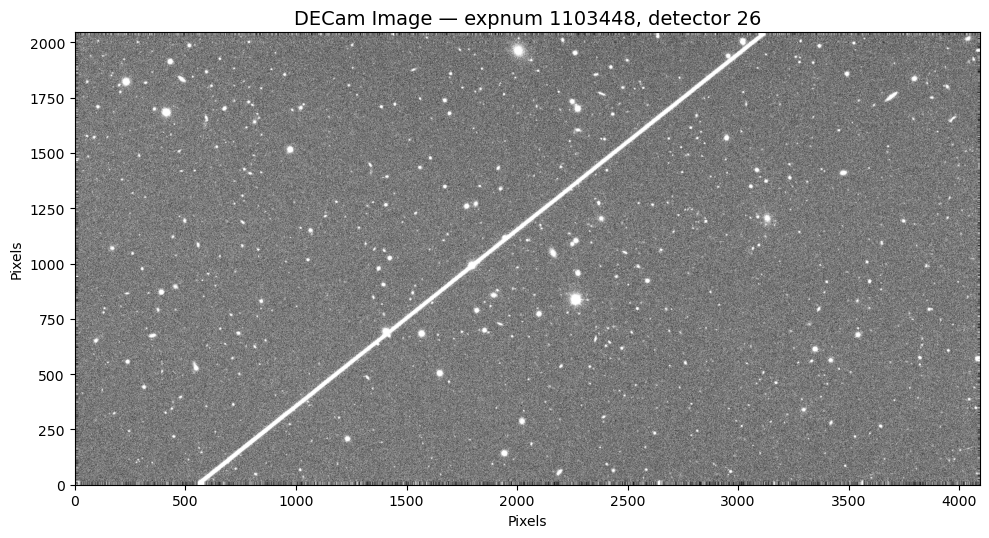

In [142]:
# Let's try with an expnum

expnum = 1103448  
detector = 26    

image_data, header, header_expnum = load_decam_image(expnum, detector)

if image_data is not None:
    plot_decam_image(image_data, expnum=expnum, detector=detector)


In [145]:
header_expnum

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
DATE    = '2022-06-09T10:44:56' / Date FITS file was generated                  
IRAF-TLM= '2022-06-09T10:45:00' / Time of last modification                     
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT MODIFIED:DATE,DATE-OBS,DTACQNAM,DTCALDAT,DTINSTRU,DTNSANAM,DTPI,DTPROPID
COMMENT ,DTSITE,DTTELESC,INSTRUME,OBSERVAT,OBSID,OBSTYPE,ODATEOBS,PROCTYPE,PRODT
COMMENT YPE,PROPID,SIMPLE,TELESCOP,TIME-OBS                                     
OBJECT  = '296.F.a '        

In [114]:
detected_lines= detect_lines_hough(image_data, threshold=0.05)

In [115]:
#detected_lines

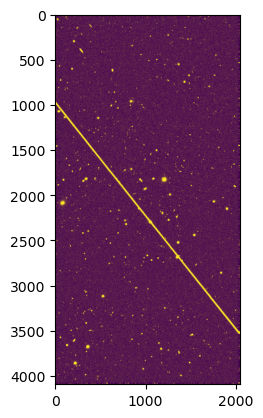

In [116]:
plt.imshow(detected_lines['Thresholded Image'])

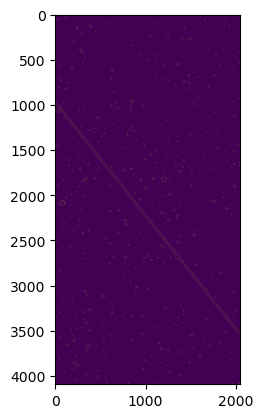

In [117]:
plt.imshow(detected_lines['Edges'])

In [118]:
clustered_lines = ld.cluster(detected_lines["Cartesian Coordinates"], detected_lines["Lines"])

In [119]:
clustered_lines

array([[-615.        ,   -0.67195176,    0.        ],
       [-596.        ,   -0.67195176,    0.        ]])

In [120]:
rotated_images, best_fit_params = ir.complete_rotate_image(
                                                clustered_lines=clustered_lines,
                                                angles=detected_lines["Angles"],
                                                image=image_data,
                                                cart_coord=detected_lines['Cartesian Coordinates'])

In [121]:
print(best_fit_params)

[{'amplitude': np.float64(248.142403227347), 'mean_brightness': np.float64(100.66861920656281), 'sigma': np.float64(-2.2800951022552263), 'fwhm': np.float64(-5.369623965811058)}]


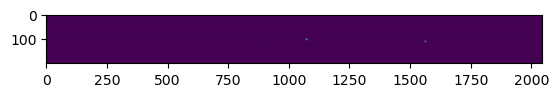

In [122]:
for image in rotated_images:
   plt.imshow(image)

(<Figure size 800x800 with 2 Axes>, <Axes: >, <Axes: >)

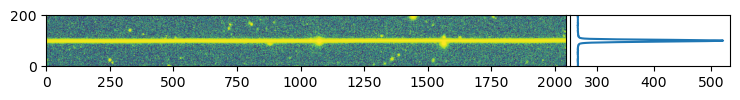

In [123]:
pixelplot.pixelplot(rotated_images[0])

In [124]:
np.savetxt('sample_image.txt', rotated_images[0])

C:\Users\ASUS\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



=== Aperture Photometry Result ===
Streak center (y0): 100.64 px
Width: σ = 3.50 px, FWHM ≈ 8.23 px
On-streak region: y = [90, 111], 42766 unmasked pixels
Off-streak regions: y = [69, 90] and [111, 132]
Signal sum (masked): 15968222.70
Background level: 268.13 counts/pixel
Empirical background: 11466993.20
Streak flux (signal - background): 4501229.50
Surface brightness: 105.25 counts/pixel²
Surface brightness: 1443.79 counts/arcsec²


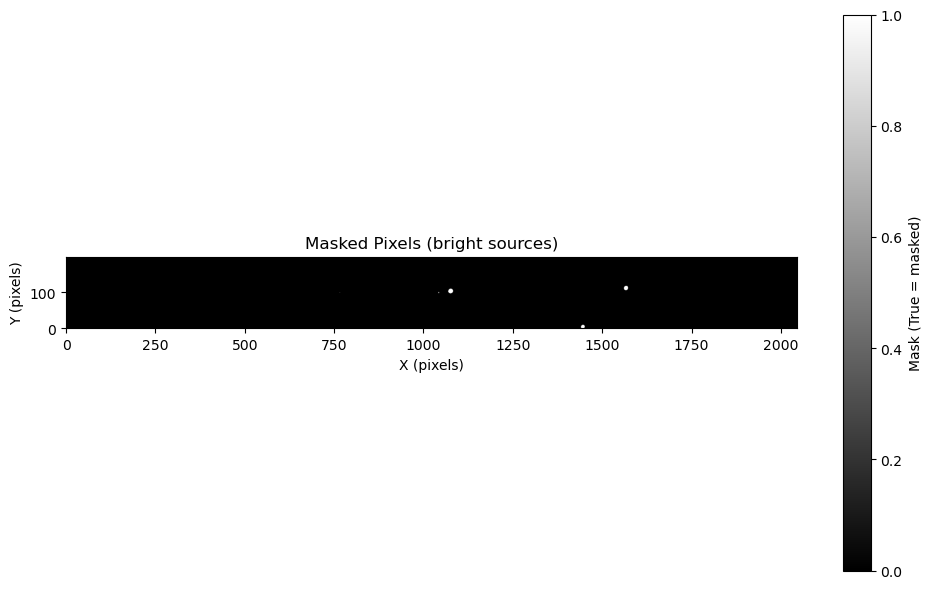

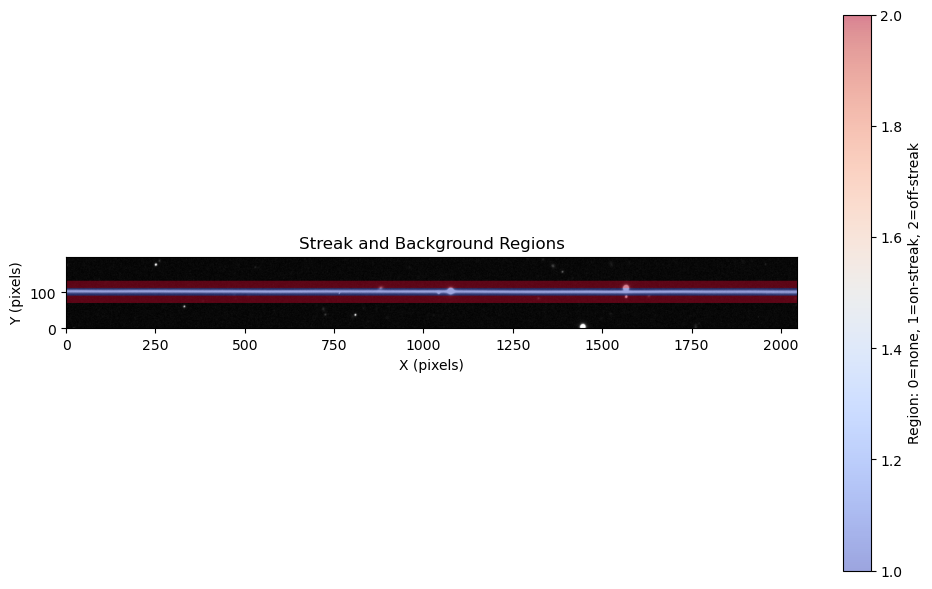

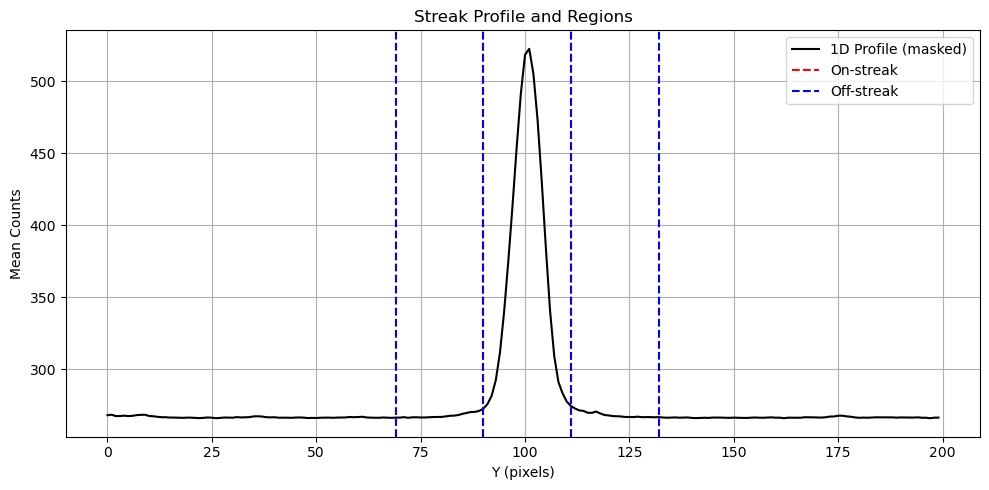

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Load image ---
image_data = rotated_images[0]

# --- Step 1: Mask bright sources ---
median = np.median(image_data)
std = np.std(image_data)
threshold = median + 3 * std
mask = image_data > threshold
masked_data = np.ma.array(image_data, mask=mask)

# --- Step 2: Collapse image to 1D profile across y ---
profile_y = np.ma.mean(masked_data, axis=1)
y = np.arange(len(profile_y))

# --- Step 3: Fit a 1D Gaussian to the profile ---
def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

# Initial guesses
A0 = profile_y.max()
y0 = y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]

popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 4: Define on-streak and off-streak regions ---
on_ymin = int(y0_fit - 3 * sigma_fit)
on_ymax = int(y0_fit + 3 * sigma_fit)
height = on_ymax - on_ymin

off1_ymin = max(0, on_ymin - height)
off1_ymax = on_ymin
off2_ymin = on_ymax
off2_ymax = min(image_data.shape[0], on_ymax + height)

# --- Create region masks for visualization ---
region_mask = np.zeros_like(image_data, dtype=int)
region_mask[on_ymin:on_ymax, :] = 1  # on-streak
region_mask[off1_ymin:off1_ymax, :] = 2  # off-streak below
region_mask[off2_ymin:off2_ymax, :] = 2  # off-streak above

# --- Step 5: Extract pixel values ---
on_region = masked_data[on_ymin:on_ymax, :]
off1_region = masked_data[off1_ymin:off1_ymax, :]
off2_region = masked_data[off2_ymin:off2_ymax, :]

on_sum = on_region.sum()
on_unmasked = np.sum(~on_region.mask)

# --- Step 6: Estimate background ---
off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
off_sum = off1_region.sum() + off2_region.sum()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked

# --- Step 7: Compute final flux and surface brightness ---
streak_flux = on_sum - empirical_bkg
pixel_scale = 0.27  # arcsec/pixel (DECam)
sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / (pixel_scale ** 2)

# --- Print results ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Signal sum (masked): {on_sum:.2f}")
print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
print(f"Empirical background: {empirical_bkg:.2f}")
print(f"Streak flux (signal - background): {streak_flux:.2f}")
print(f"Surface brightness: {sb_pixel:.2f} counts/pixel²")
print(f"Surface brightness: {sb_arcsec:.2f} counts/arcsec²")

# --- Plot 1: Masked pixels ---
plt.figure(figsize=(10, 6))
plt.imshow(mask, origin='lower', cmap='gray')
plt.title("Masked Pixels (bright sources)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Mask (True = masked)')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 2: Region overlay on original image ---
plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
           origin='lower', cmap='coolwarm', alpha=0.5)
plt.title("Streak and Background Regions")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 3: 1D profile with region markers ---
plt.figure(figsize=(10, 5))
plt.plot(y, profile_y, label="1D Profile (masked)", color='black')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean Counts")
plt.title("Streak Profile and Regions")
plt.grid(True)
plt.tight_layout()
plt.show()

## Let's try with other expnums

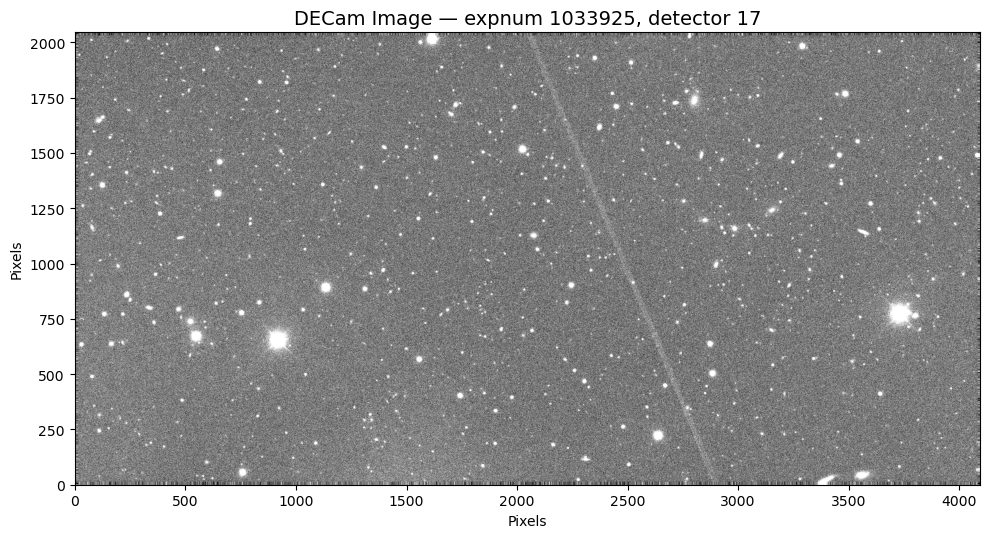

In [149]:
expnum = 1033925  
detector =  17 

image_data, header, header_expnum = load_decam_image(expnum, detector)

if image_data is not None:
    plot_decam_image(image_data, expnum=expnum, detector=detector)

[[  0 255   0 ...   0 255   0]
 [  0 255   0 ...   0 255   0]
 [  0   0 255 ...   0   0   0]
 ...
 [  0 255 255 ... 255 255   0]
 [  0 255 255 ... 255 255   0]
 [255 255 255 ... 255 255 255]]


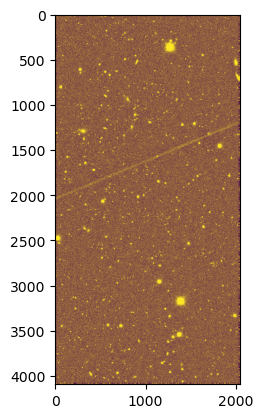

In [150]:
detected_lines= detect_lines_hough(image_data, 
                                   brightness_cuts= (3,5), thresholding_cut=0.08) 
                                   #flux_prop_thresholds=[0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1.0],
                                   #blur_kernel_sizes= [2, 3, 4, 5, 9, 11, 15, 17])
plt.imshow(detected_lines['Thresholded Image'])
print(detected_lines['Thresholded Image'])

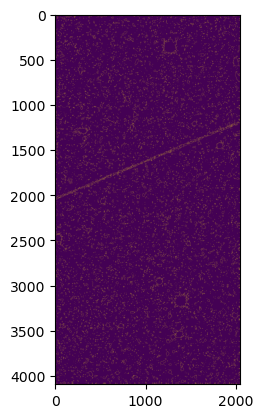

In [151]:
plt.imshow(detected_lines['Edges'])

In [152]:
clustered_lines = ld.cluster(detected_lines["Cartesian Coordinates"], detected_lines["Lines"])

In [153]:
print(detected_lines.keys())
for k, v in detected_lines.items():
    print(k, len(v))


dict_keys(['Lines', 'Angles', 'Cartesian Coordinates', 'Thresholded Image', 'Blurred Image', 'Edges'])
Lines 1
Angles 1
Cartesian Coordinates 1
Thresholded Image 4094
Blurred Image 4094
Edges 4094


In [154]:
rotated_images, best_fit_params = ir.complete_rotate_image(
                                                clustered_lines=clustered_lines,
                                                angles=detected_lines["Angles"],
                                                image=image_data,
                                                cart_coord=detected_lines['Cartesian Coordinates'])

(<Figure size 800x800 with 2 Axes>, <Axes: >, <Axes: >)

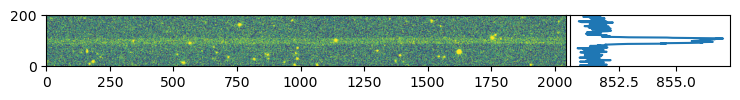

In [155]:
pixelplot.pixelplot(rotated_images[0])

In [157]:
zeropoint= header_expnum['MAGZERO']

In [ ]:
print(clustered_lines)

C:\Users\ASUS\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



=== Aperture Photometry Result ===
Streak center (y0): 101.63 px
Width: σ = 9.07 px, FWHM ≈ 21.36 px
On-streak region: y = [74, 128], 110396 unmasked pixels
Off-streak regions: y = [20, 74] and [128, 182]
Signal sum (masked): 94262693.63
Background level: 851.66 counts/pixel
Empirical background: 94019993.98
Streak flux (signal - background): 242699.65
Surface brightness: 2.20 counts/pixel²
Surface brightness: 30.16 counts/arcsec²


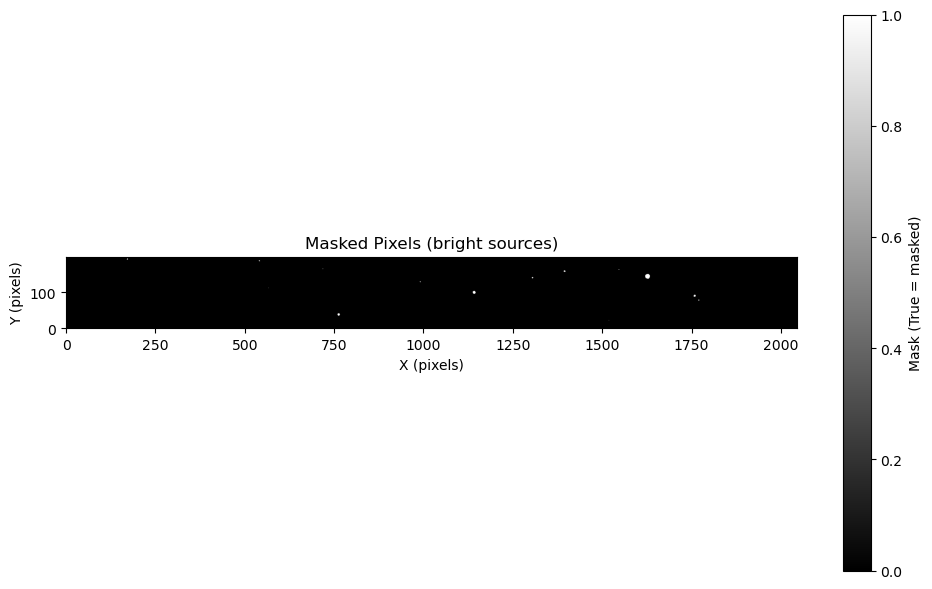

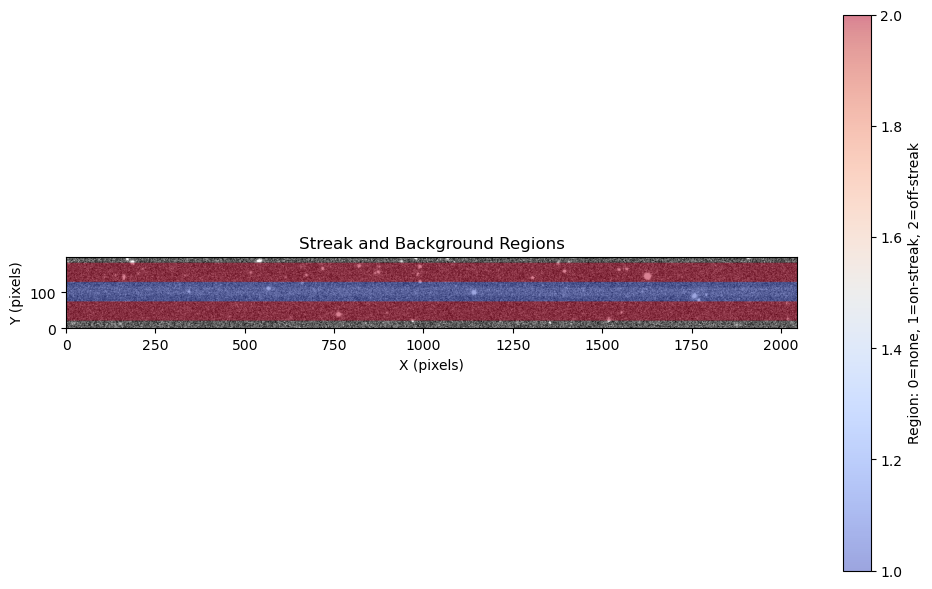

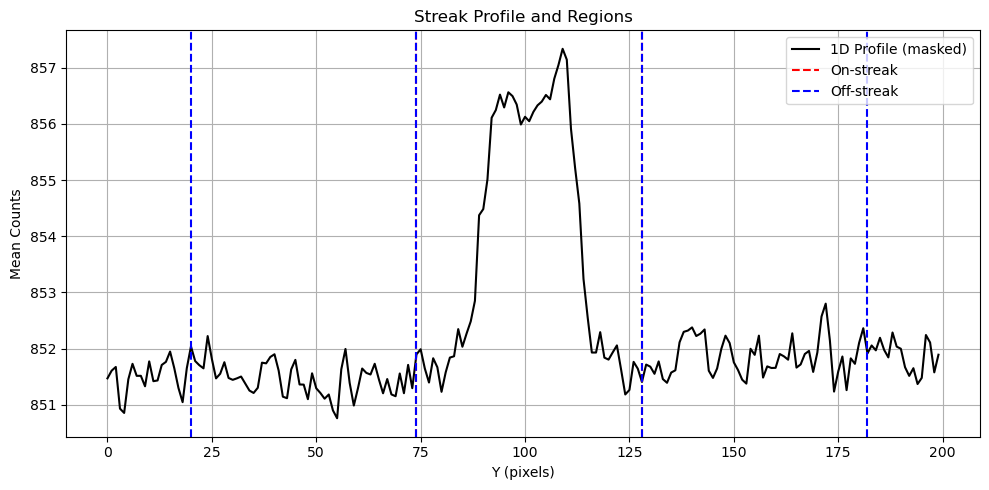

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Load image ---
image_data = rotated_images[0]

# --- Step 1: Mask bright sources ---
median = np.median(image_data)
std = np.std(image_data)
threshold = median + 3 * std
mask = image_data > threshold
masked_data = np.ma.array(image_data, mask=mask)

# --- Step 2: Collapse image to 1D profile across y ---
profile_y = np.ma.mean(masked_data, axis=1)
y = np.arange(len(profile_y))

# --- Step 3: Fit a 1D Gaussian to the profile ---
def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

# Initial guesses
A0 = profile_y.max()
y0 = y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]

popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 4: Define on-streak and off-streak regions ---
on_ymin = int(y0_fit - 3 * sigma_fit)
on_ymax = int(y0_fit + 3 * sigma_fit)
height = on_ymax - on_ymin

off1_ymin = max(0, on_ymin - height)
off1_ymax = on_ymin
off2_ymin = on_ymax
off2_ymax = min(image_data.shape[0], on_ymax + height)

# --- Create region masks for visualization ---
region_mask = np.zeros_like(image_data, dtype=int)
region_mask[on_ymin:on_ymax, :] = 1  # on-streak
region_mask[off1_ymin:off1_ymax, :] = 2  # off-streak below
region_mask[off2_ymin:off2_ymax, :] = 2  # off-streak above

# --- Step 5: Extract pixel values ---
on_region = masked_data[on_ymin:on_ymax, :]
off1_region = masked_data[off1_ymin:off1_ymax, :]
off2_region = masked_data[off2_ymin:off2_ymax, :]

on_sum = on_region.sum()
on_unmasked = np.sum(~on_region.mask)

# --- Step 6: Estimate background ---
off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
off_sum = off1_region.sum() + off2_region.sum()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked

# --- Step 7: Compute final flux and surface brightness ---
streak_flux = on_sum - empirical_bkg
pixel_scale = 0.27  # arcsec/pixel (DECam)
sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / (pixel_scale ** 2)

# --- Print results ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Signal sum (masked): {on_sum:.2f}")
print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
print(f"Empirical background: {empirical_bkg:.2f}")
print(f"Streak flux (signal - background): {streak_flux:.2f}")
print(f"Surface brightness: {sb_pixel:.2f} counts/pixel²")
print(f"Surface brightness: {sb_arcsec:.2f} counts/arcsec²")

# --- Plot 1: Masked pixels ---
plt.figure(figsize=(10, 6))
plt.imshow(mask, origin='lower', cmap='gray')
plt.title("Masked Pixels (bright sources)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Mask (True = masked)')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 2: Region overlay on original image ---
plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
           origin='lower', cmap='coolwarm', alpha=0.5)
plt.title("Streak and Background Regions")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 3: 1D profile with region markers ---
plt.figure(figsize=(10, 5))
plt.plot(y, profile_y, label="1D Profile (masked)", color='black')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean Counts")
plt.title("Streak Profile and Regions")
plt.grid(True)
plt.tight_layout()
plt.show()


=== Aperture Photometry Result ===
Streak center (y0): 101.63 px
Width: σ = 9.07 px, FWHM ≈ 21.36 px
On-streak region: y = [74, 128], 110396 unmasked pixels
Streak flux: 242699.65
Surface brightness: 30.16 ± 0.13 counts/arcsec² [background-dominated]

=== Aperture Photometry Result ===
Streak center (y0): 101.63 px
Width: σ = 9.07 px, FWHM ≈ 21.36 px
On-streak region: y = [74, 128], 110396 unmasked pixels
Off-streak regions: y = [20, 74] and [128, 182]
Signal sum (masked): 94262693.63
Background level: 851.66 counts/pixel
Empirical background: 94019993.98
Streak flux (signal - background): 242699.65
Noise regime: background-dominated
Surface brightness: 2.20 ± 0.01 counts/pixel²
Surface brightness: 30.16 ± 0.13 counts/arcsec²


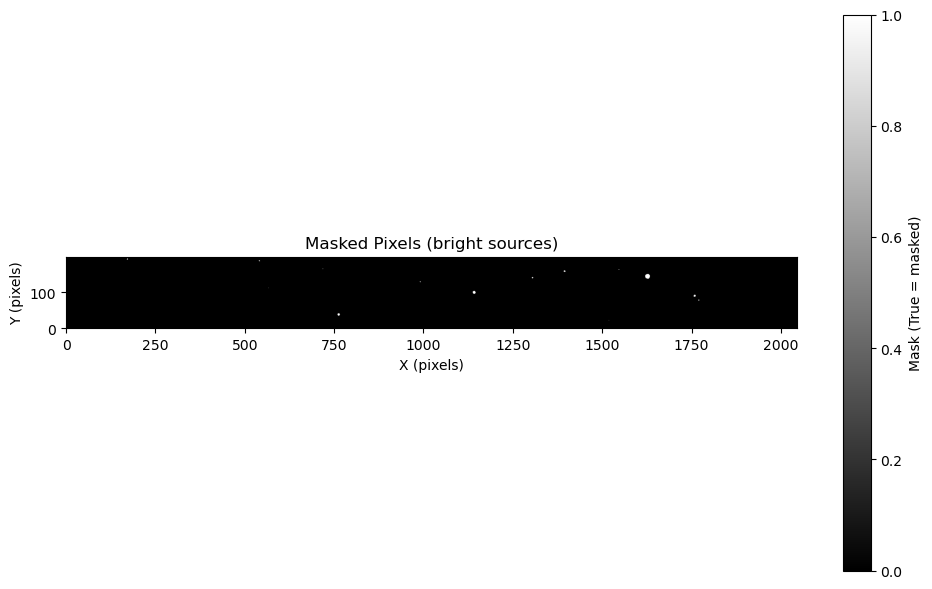

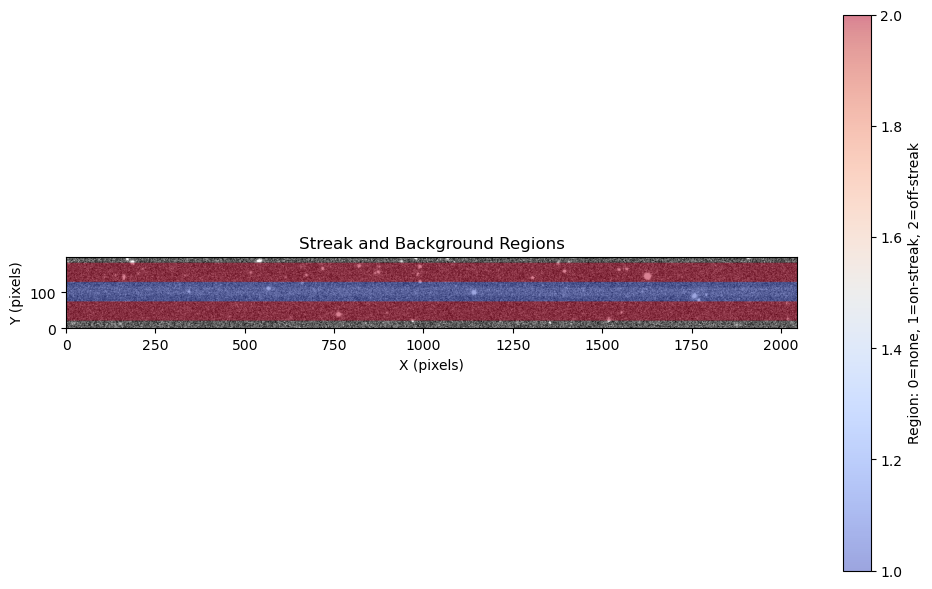

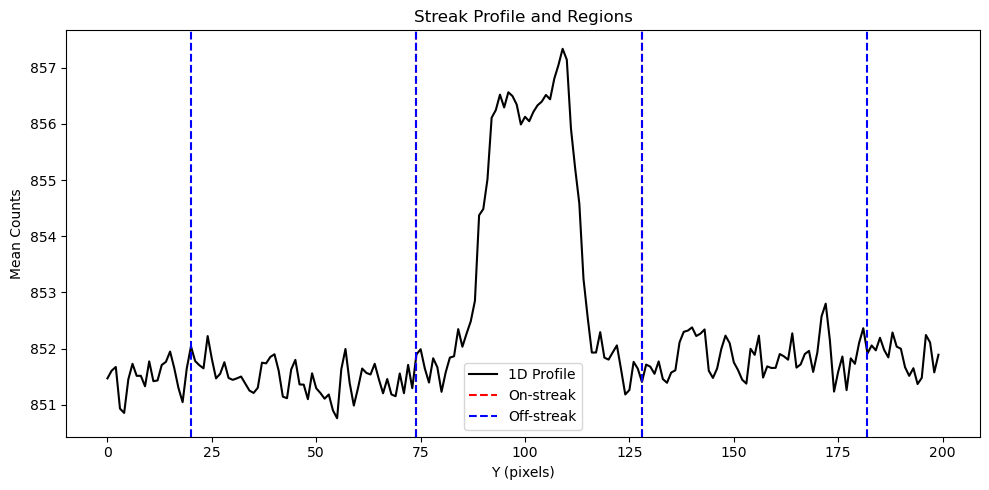

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits

# --- Load image ---
image_data  

# Simulated FITS header
header = {
    "GAINA": 3.77,
    "GAINB": 3.74,
    "RDNOISEA": 5.92,
    "RDNOISEB": 5.87
}

gain = 0.5 * (header["GAINA"] + header["GAINB"])
read_noise = 0.5 * (header["RDNOISEA"] + header["RDNOISEB"])

# --- Step 1: Mask bright sources ---
median = np.median(image_data)
std = np.std(image_data)
threshold = median + 3 * std
mask = image_data > threshold
masked_data = np.ma.array(image_data, mask=mask)

# --- Step 2: Collapse image to 1D profile across y ---
profile_y = np.ma.mean(masked_data, axis=1)
y = np.arange(len(profile_y))

# --- Step 3: Fit a 1D Gaussian to the profile ---
def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

A0 = profile_y.max()
y0 = y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]
popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 4: Define on-streak and off-streak regions ---
on_ymin = int(y0_fit - 3 * sigma_fit)
on_ymax = int(y0_fit + 3 * sigma_fit)
height = on_ymax - on_ymin

off1_ymin = max(0, on_ymin - height)
off1_ymax = on_ymin
off2_ymin = on_ymax
off2_ymax = min(image_data.shape[0], on_ymax + height)

region_mask = np.zeros_like(image_data, dtype=int)
region_mask[on_ymin:on_ymax, :] = 1
region_mask[off1_ymin:off1_ymax, :] = 2
region_mask[off2_ymin:off2_ymax, :] = 2

# --- Step 5: Extract pixel values ---
on_region = masked_data[on_ymin:on_ymax, :]
off1_region = masked_data[off1_ymin:off1_ymax, :]
off2_region = masked_data[off2_ymin:off2_ymax, :]

on_sum = on_region.sum()
on_unmasked = np.sum(~on_region.mask)

# --- Step 6: Estimate background ---
off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
off_sum = off1_region.sum() + off2_region.sum()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked

# --- Step 7: Final flux and surface brightness ---
streak_flux = on_sum - empirical_bkg
pixel_scale = 0.27
sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / (pixel_scale ** 2)

# --- Step 8: Error estimation ---
def estimate_flux_uncertainty(streak_flux, on_unmasked, bkg_std, gain, read_noise):
    flux_e = gain * streak_flux
    signal_per_pixel = flux_e / on_unmasked
    noise_background = on_unmasked * (bkg_std**2 + read_noise**2)
    if signal_per_pixel < 5 * bkg_std:
        regime = "background-dominated"
        flux_var = noise_background
    else:
        regime = "source-dominated"
        flux_var = flux_e + noise_background
    flux_err = np.sqrt(flux_var) / gain  # back to ADU
    return flux_err, regime

off_vals = np.hstack([
    off1_region[~off1_region.mask].ravel(),
    off2_region[~off2_region.mask].ravel()
])
bkg_std = np.std(off_vals)

flux_err, regime = estimate_flux_uncertainty(streak_flux, on_unmasked, bkg_std, gain, read_noise)
sb_pixel_err = flux_err / on_unmasked
sb_arcsec_err = sb_pixel_err / pixel_scale**2

# --- Output ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Streak flux: {streak_flux:.2f}")
print(f"Surface brightness: {sb_arcsec:.2f} ± {sb_arcsec_err:.2f} counts/arcsec² [{regime}]")


# --- Final Output Summary ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Signal sum (masked): {on_sum:.2f}")
print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
print(f"Empirical background: {empirical_bkg:.2f}")
print(f"Streak flux (signal - background): {streak_flux:.2f}")
print(f"Noise regime: {regime}")

print(f"Surface brightness: {sb_pixel:.2f} ± {sb_pixel_err:.2f} counts/pixel²")
print(f"Surface brightness: {sb_arcsec:.2f} ± {sb_arcsec_err:.2f} counts/arcsec²")


# --- Plots ---
plt.figure(figsize=(10, 6))
plt.imshow(mask, origin='lower', cmap='gray')
plt.title("Masked Pixels (bright sources)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Mask (True = masked)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
           origin='lower', cmap='coolwarm', alpha=0.5)
plt.title("Streak and Background Regions")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y, profile_y, label="1D Profile", color='black')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean Counts")
plt.title("Streak Profile and Regions")
plt.tight_layout()
plt.show()

In [161]:
# --- Step 9: Convert to mag/arcsec² using MAGZERO ---
zeropoint = header_expnum['MAGZERO']  # from header['MAGZERO']

# Surface brightness in mag/arcsec²
sb_mag_arcsec2 = -2.5 * np.log10(sb_arcsec) + zeropoint

# Error propagation
sb_mag_arcsec2_err = 1.0857 * (sb_arcsec_err / sb_arcsec)  # this part may be wrong

# Output
print(f"Surface brightness: {sb_mag_arcsec2:.3f} ± {sb_mag_arcsec2_err:.3f} mag/arcsec²")

        #print(f"Surface brightness: {sb_mag_arcsec2:.5f} ± {sb_mag_arcsec2_err:.5f} mag/arcsec²")

Surface brightness: 25.752 ± 0.005 mag/arcsec²


### OTHER EXPNUM 

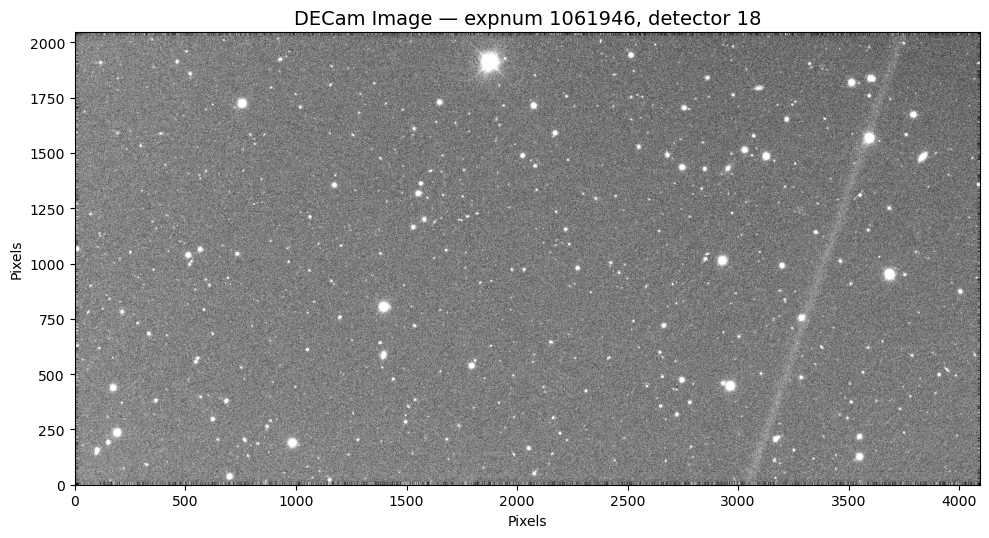

In [80]:
expnum =   1061946
detector =  18  

image_data, header = load_decam_image(expnum, detector)

if image_data is not None:
    plot_decam_image(image_data, expnum=expnum, detector=detector)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0 255   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 255   0   0]]


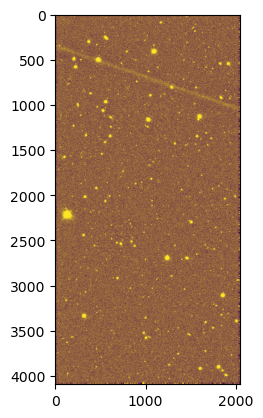

In [81]:
detected_lines= detect_lines_hough(image_data, 
                                   brightness_cuts= (3,5), thresholding_cut=0.08) 
                                   #flux_prop_thresholds=[0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1.0],
                                   #blur_kernel_sizes= [2, 3, 4, 5, 9, 11, 15, 17])
plt.imshow(detected_lines['Thresholded Image'])
print(detected_lines['Thresholded Image'])

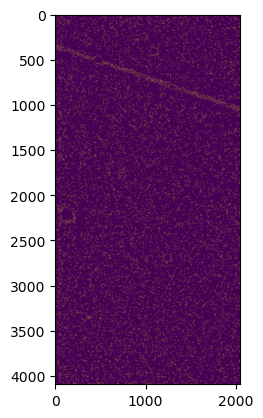

In [82]:
plt.imshow(detected_lines['Edges'])

In [83]:
clustered_lines = ld.cluster(detected_lines["Cartesian Coordinates"], detected_lines["Lines"])

In [84]:
print(detected_lines.keys())
for k, v in detected_lines.items():
    print(k, len(v))


dict_keys(['Lines', 'Angles', 'Cartesian Coordinates', 'Thresholded Image', 'Blurred Image', 'Edges'])
Lines 2
Angles 2
Cartesian Coordinates 2
Thresholded Image 4094
Blurred Image 4094
Edges 4094


In [85]:
rotated_images, best_fit_params = ir.complete_rotate_image(
                                                clustered_lines=clustered_lines,
                                                angles=detected_lines["Angles"],
                                                image=image_data,
                                                cart_coord=detected_lines['Cartesian Coordinates'])

(<Figure size 800x800 with 2 Axes>, <Axes: >, <Axes: >)

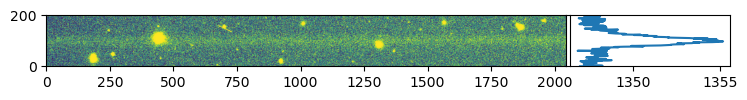

In [86]:
pixelplot.pixelplot(rotated_images[0])

C:\Users\ASUS\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



=== Aperture Photometry Result ===
Streak center (y0): 98.76 px
Width: σ = 14.37 px, FWHM ≈ 33.85 px
On-streak region: y = [55, 141], 175547 unmasked pixels
Off-streak regions: y = [0, 55] and [141, 200]
Signal sum (masked): 237428622.56
Background level: 1349.03 counts/pixel
Empirical background: 236817807.87
Streak flux (signal - background): 610814.69
Surface brightness: 3.48 counts/pixel²
Surface brightness: 47.73 counts/arcsec²


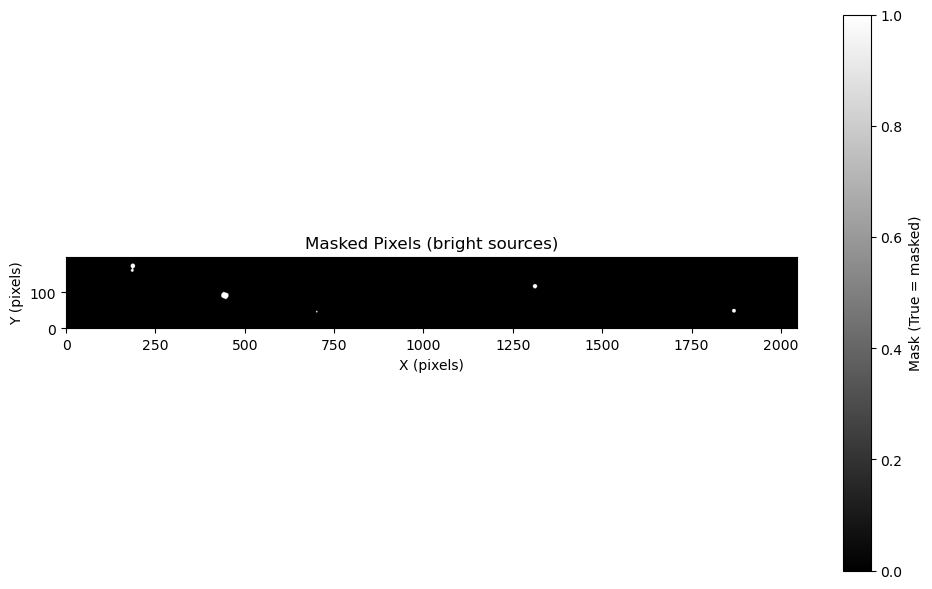

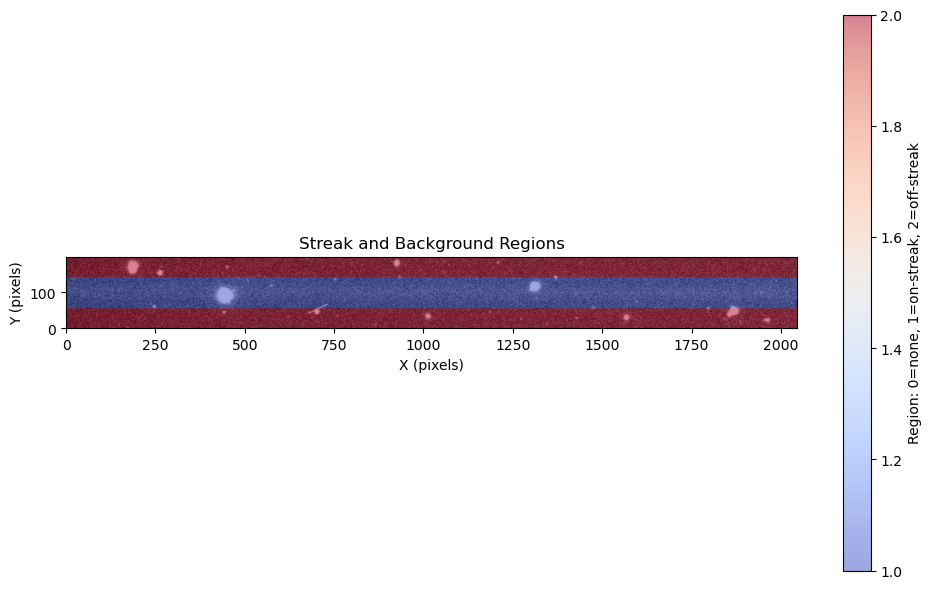

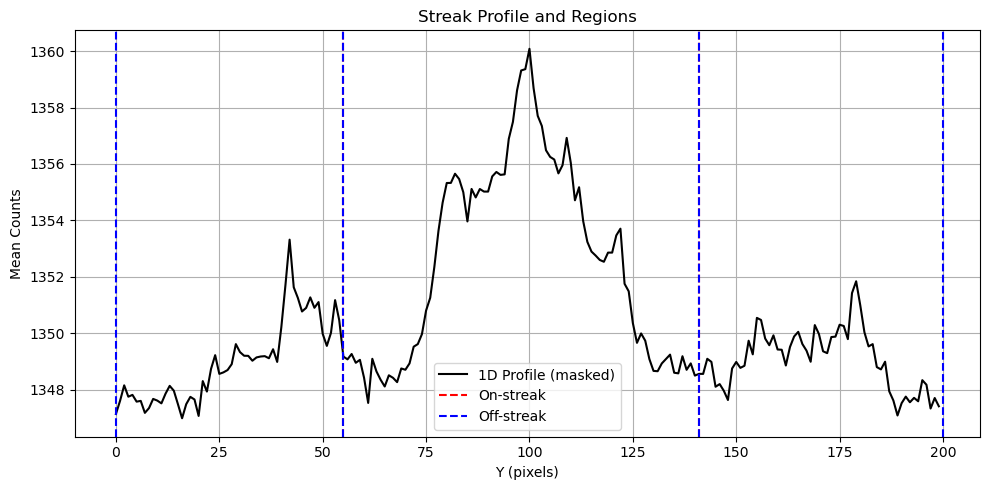

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Load image ---
image_data = rotated_images[0]

# --- Step 1: Mask bright sources ---
median = np.median(image_data)
std = np.std(image_data)
threshold = median + 3 * std
mask = image_data > threshold
masked_data = np.ma.array(image_data, mask=mask)

# --- Step 2: Collapse image to 1D profile across y ---
profile_y = np.ma.mean(masked_data, axis=1)
y = np.arange(len(profile_y))

# --- Step 3: Fit a 1D Gaussian to the profile ---
def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

# Initial guesses
A0 = profile_y.max()
y0 = y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]

popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 4: Define on-streak and off-streak regions ---
on_ymin = int(y0_fit - 3 * sigma_fit)
on_ymax = int(y0_fit + 3 * sigma_fit)
height = on_ymax - on_ymin

off1_ymin = max(0, on_ymin - height)
off1_ymax = on_ymin
off2_ymin = on_ymax
off2_ymax = min(image_data.shape[0], on_ymax + height)

# --- Create region masks for visualization ---
region_mask = np.zeros_like(image_data, dtype=int)
region_mask[on_ymin:on_ymax, :] = 1  # on-streak
region_mask[off1_ymin:off1_ymax, :] = 2  # off-streak below
region_mask[off2_ymin:off2_ymax, :] = 2  # off-streak above

# --- Step 5: Extract pixel values ---
on_region = masked_data[on_ymin:on_ymax, :]
off1_region = masked_data[off1_ymin:off1_ymax, :]
off2_region = masked_data[off2_ymin:off2_ymax, :]

on_sum = on_region.sum()
on_unmasked = np.sum(~on_region.mask)

# --- Step 6: Estimate background ---
off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
off_sum = off1_region.sum() + off2_region.sum()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked

# --- Step 7: Compute final flux and surface brightness ---
streak_flux = on_sum - empirical_bkg
pixel_scale = 0.27  # arcsec/pixel (DECam)
sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / (pixel_scale ** 2)

# --- Print results ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Signal sum (masked): {on_sum:.2f}")
print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
print(f"Empirical background: {empirical_bkg:.2f}")
print(f"Streak flux (signal - background): {streak_flux:.2f}")
print(f"Surface brightness: {sb_pixel:.2f} counts/pixel²")
print(f"Surface brightness: {sb_arcsec:.2f} counts/arcsec²")

# --- Plot 1: Masked pixels ---
plt.figure(figsize=(10, 6))
plt.imshow(mask, origin='lower', cmap='gray')
plt.title("Masked Pixels (bright sources)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Mask (True = masked)')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 2: Region overlay on original image ---
plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
           origin='lower', cmap='coolwarm', alpha=0.5)
plt.title("Streak and Background Regions")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 3: 1D profile with region markers ---
plt.figure(figsize=(10, 5))
plt.plot(y, profile_y, label="1D Profile (masked)", color='black')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean Counts")
plt.title("Streak Profile and Regions")
plt.grid(True)
plt.tight_layout()
plt.show()

## ONE MOREEEE

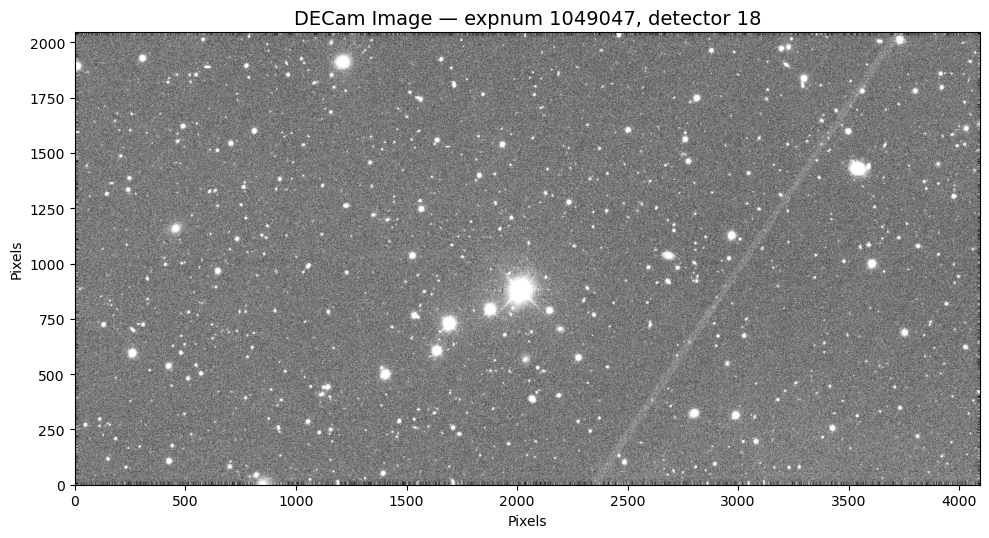

In [45]:
expnum =   1049047
detector =  18  

image_data, header = load_decam_image(expnum, detector)

if image_data is not None:
    plot_decam_image(image_data, expnum=expnum, detector=detector)

[[  0 255   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0 255   0 ... 255 255   0]
 [  0 255   0 ...   0 255   0]
 [  0 255   0 ... 255 255 255]]


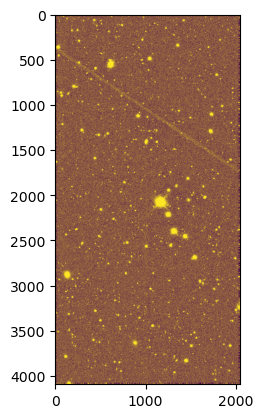

In [46]:
detected_lines= detect_lines_hough(image_data, 
                                   brightness_cuts= (3,5), thresholding_cut=0.06) 
                                   #flux_prop_thresholds=[0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1.0],
                                   #blur_kernel_sizes= [2, 3, 4, 5, 9, 11, 15, 17])
plt.imshow(detected_lines['Thresholded Image'])
print(detected_lines['Thresholded Image'])

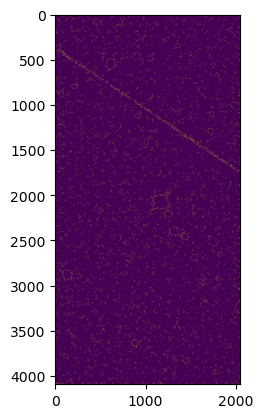

In [47]:
plt.imshow(detected_lines['Edges'])

In [48]:
clustered_lines = ld.cluster(detected_lines["Cartesian Coordinates"], detected_lines["Lines"])

In [49]:
print(detected_lines.keys())
for k, v in detected_lines.items():
    print(k, len(v))


dict_keys(['Lines', 'Angles', 'Cartesian Coordinates', 'Thresholded Image', 'Blurred Image', 'Edges'])
Lines 1
Angles 1
Cartesian Coordinates 1
Thresholded Image 4094
Blurred Image 4094
Edges 4094


In [50]:
rotated_images, best_fit_params = ir.complete_rotate_image(
                                                clustered_lines=clustered_lines,
                                                angles=detected_lines["Angles"],
                                                image=image_data,
                                                cart_coord=detected_lines['Cartesian Coordinates'])

(<Figure size 800x800 with 2 Axes>, <Axes: >, <Axes: >)

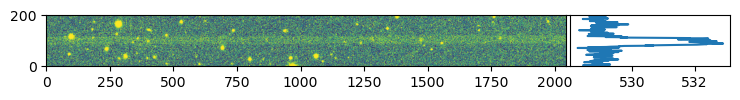

In [51]:
pixelplot.pixelplot(rotated_images[0])

In [52]:
print(rotated_images)

[array([[536.60806298, 525.73089308, 510.21855783, ..., 535.62055582,
        537.91708517, 529.17643106],
       [533.25481033, 523.77481544, 521.60604858, ..., 529.55284506,
        538.93993592, 534.07858777],
       [521.28296816, 519.89488316, 526.64101017, ..., 530.41636336,
        536.26250887, 532.76066399],
       ...,
       [526.76374888, 529.27182448, 539.05385232, ..., 530.15886545,
        537.36284739, 529.92906111],
       [523.96900058, 527.12740898, 543.12291718, ..., 515.48318338,
        518.01996732, 521.39805484],
       [521.37210631, 536.79081488, 556.87170696, ..., 511.27655745,
        512.6225729 , 534.61757845]])]



=== Aperture Photometry Result ===
Streak center (y0): 98.76 px
Width: σ = 14.37 px, FWHM ≈ 33.85 px
On-streak region: y = [55, 141], 175547 unmasked pixels
Off-streak regions: y = [0, 55] and [141, 200]
Signal sum (masked): 237428622.56
Background level: 1349.03 counts/pixel
Empirical background: 236817807.87
Streak flux (signal - background): 610814.69
Surface brightness: 3.48 counts/pixel²
Surface brightness: 47.73 counts/arcsec²


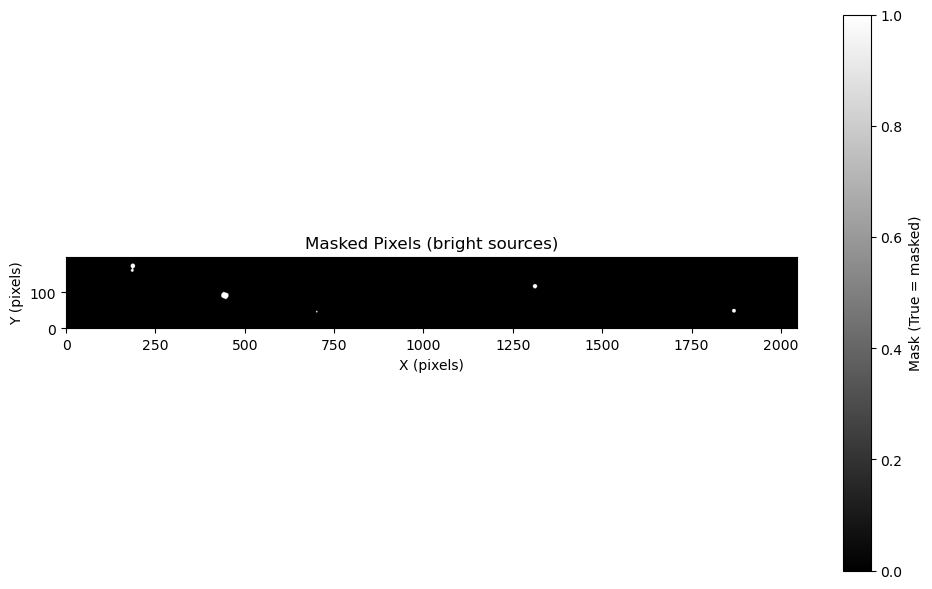

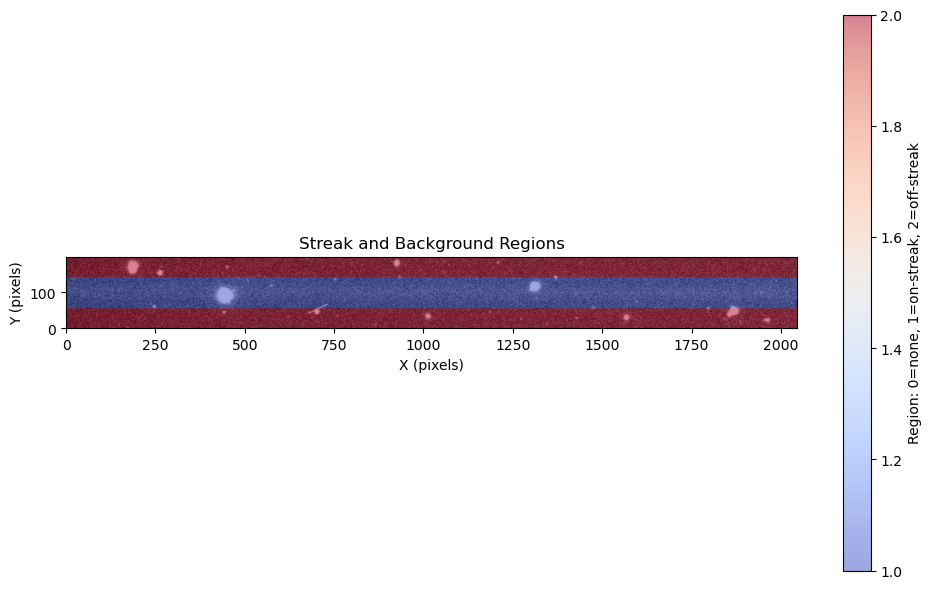

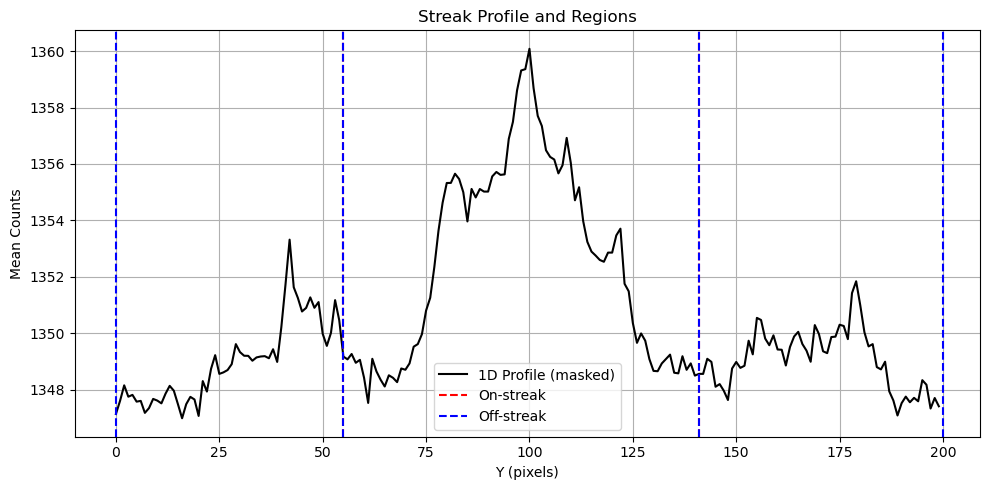

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Load image ---
image_data = rotated_images[0]

# --- Step 1: Mask bright sources ---
median = np.median(image_data)
std = np.std(image_data)
threshold = median + 3 * std
mask = image_data > threshold
masked_data = np.ma.array(image_data, mask=mask)

# --- Step 2: Collapse image to 1D profile across y ---
profile_y = np.ma.mean(masked_data, axis=1)
y = np.arange(len(profile_y))

# --- Step 3: Fit a 1D Gaussian to the profile ---
def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

# Initial guesses
A0 = profile_y.max()
y0 = y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]

popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 4: Define on-streak and off-streak regions ---
on_ymin = int(y0_fit - 3 * sigma_fit)
on_ymax = int(y0_fit + 3 * sigma_fit)
height = on_ymax - on_ymin

off1_ymin = max(0, on_ymin - height)
off1_ymax = on_ymin
off2_ymin = on_ymax
off2_ymax = min(image_data.shape[0], on_ymax + height)

# --- Create region masks for visualization ---
region_mask = np.zeros_like(image_data, dtype=int)
region_mask[on_ymin:on_ymax, :] = 1  # on-streak
region_mask[off1_ymin:off1_ymax, :] = 2  # off-streak below
region_mask[off2_ymin:off2_ymax, :] = 2  # off-streak above

# --- Step 5: Extract pixel values ---
on_region = masked_data[on_ymin:on_ymax, :]
off1_region = masked_data[off1_ymin:off1_ymax, :]
off2_region = masked_data[off2_ymin:off2_ymax, :]

on_sum = on_region.sum()
on_unmasked = np.sum(~on_region.mask)

# --- Step 6: Estimate background ---
off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
off_sum = off1_region.sum() + off2_region.sum()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked

# --- Step 7: Compute final flux and surface brightness ---
streak_flux = on_sum - empirical_bkg
pixel_scale = 0.27  # arcsec/pixel (DECam)
sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / (pixel_scale ** 2)

# --- Print results ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Signal sum (masked): {on_sum:.2f}")
print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
print(f"Empirical background: {empirical_bkg:.2f}")
print(f"Streak flux (signal - background): {streak_flux:.2f}")
print(f"Surface brightness: {sb_pixel:.2f} counts/pixel²")
print(f"Surface brightness: {sb_arcsec:.2f} counts/arcsec²")

# --- Plot 1: Masked pixels ---
plt.figure(figsize=(10, 6))
plt.imshow(mask, origin='lower', cmap='gray')
plt.title("Masked Pixels (bright sources)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Mask (True = masked)')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 2: Region overlay on original image ---
plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
           origin='lower', cmap='coolwarm', alpha=0.5)
plt.title("Streak and Background Regions")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 3: 1D profile with region markers ---
plt.figure(figsize=(10, 5))
plt.plot(y, profile_y, label="1D Profile (masked)", color='black')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean Counts")
plt.title("Streak Profile and Regions")
plt.grid(True)
plt.tight_layout()
plt.show()


=== Aperture Photometry Result ===
Streak center (y0): 100.64 px
Width: σ = 3.50 px, FWHM ≈ 8.23 px
On-streak region: y = [90, 111], 42766 unmasked pixels
Streak flux: 4501229.50
Surface brightness: 1443.79 ± 0.46 counts/arcsec² [source-dominated]

=== Aperture Photometry Result ===
Streak center (y0): 100.64 px
Width: σ = 3.50 px, FWHM ≈ 8.23 px
On-streak region: y = [90, 111], 42766 unmasked pixels
Off-streak regions: y = [69, 90] and [111, 132]
Signal sum (masked): 15968222.70
Background level: 268.13 counts/pixel
Empirical background: 11466993.20
Streak flux (signal - background): 4501229.50
Noise regime: source-dominated
Surface brightness: 105.25 ± 0.03 counts/pixel²
Surface brightness: 1443.79 ± 0.46 counts/arcsec²


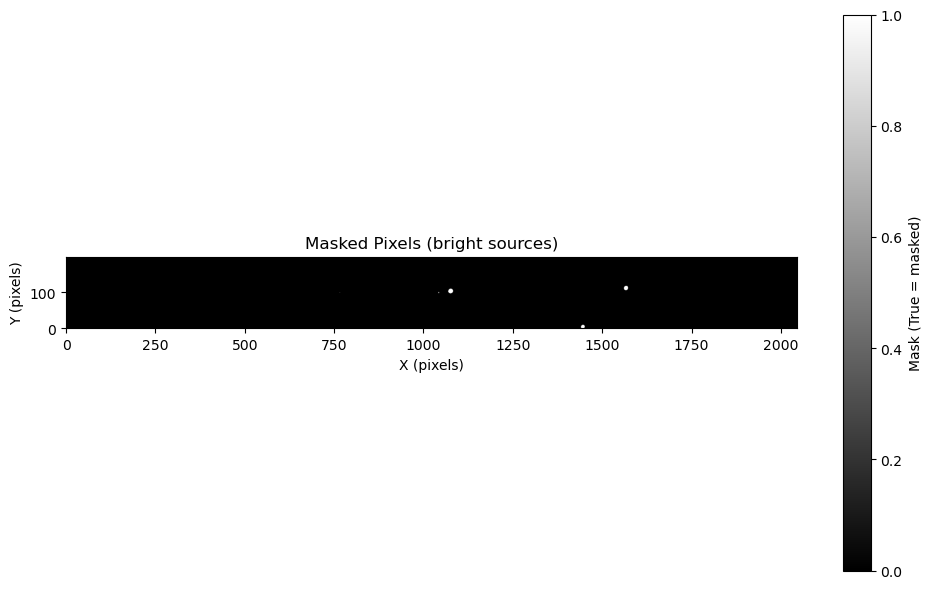

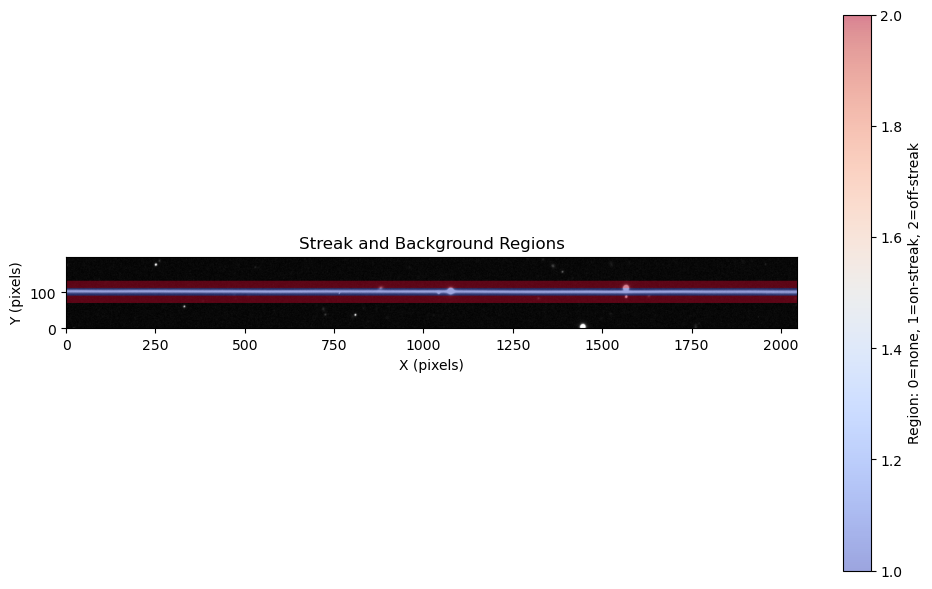

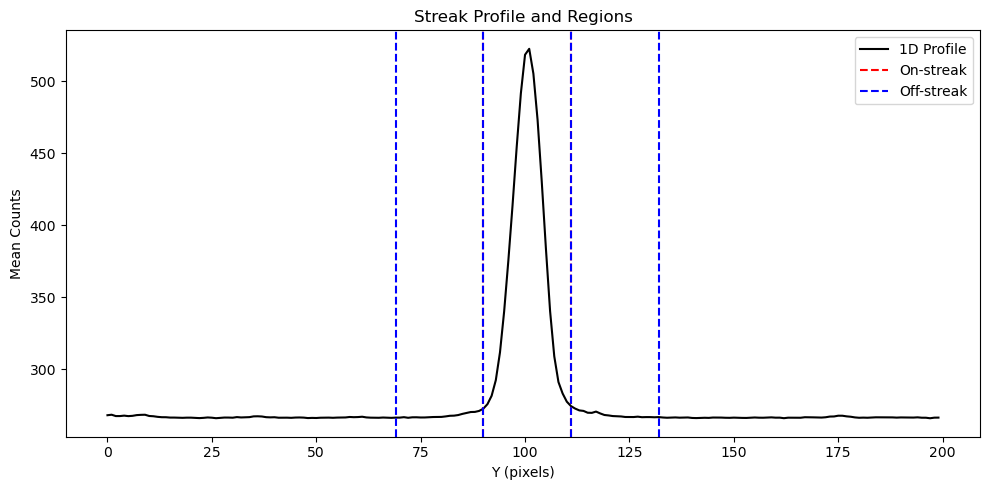

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits

# --- Load image ---
image_data = np.loadtxt("sample_image.txt")  

# Simulated FITS header
header = {
    "GAINA": 3.77,
    "GAINB": 3.74,
    "RDNOISEA": 5.92,
    "RDNOISEB": 5.87
}

gain = 0.5 * (header["GAINA"] + header["GAINB"])
read_noise = 0.5 * (header["RDNOISEA"] + header["RDNOISEB"])

# --- Step 1: Mask bright sources ---
median = np.median(image_data)
std = np.std(image_data)
threshold = median + 3 * std
mask = image_data > threshold
masked_data = np.ma.array(image_data, mask=mask)

# --- Step 2: Collapse image to 1D profile across y ---
profile_y = np.ma.mean(masked_data, axis=1)
y = np.arange(len(profile_y))

# --- Step 3: Fit a 1D Gaussian to the profile ---
def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

A0 = profile_y.max()
y0 = y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]
popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 4: Define on-streak and off-streak regions ---
on_ymin = int(y0_fit - 3 * sigma_fit)
on_ymax = int(y0_fit + 3 * sigma_fit)
height = on_ymax - on_ymin

off1_ymin = max(0, on_ymin - height)
off1_ymax = on_ymin
off2_ymin = on_ymax
off2_ymax = min(image_data.shape[0], on_ymax + height)

region_mask = np.zeros_like(image_data, dtype=int)
region_mask[on_ymin:on_ymax, :] = 1
region_mask[off1_ymin:off1_ymax, :] = 2
region_mask[off2_ymin:off2_ymax, :] = 2

# --- Step 5: Extract pixel values ---
on_region = masked_data[on_ymin:on_ymax, :]
off1_region = masked_data[off1_ymin:off1_ymax, :]
off2_region = masked_data[off2_ymin:off2_ymax, :]

on_sum = on_region.sum()
on_unmasked = np.sum(~on_region.mask)

# --- Step 6: Estimate background ---
off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
off_sum = off1_region.sum() + off2_region.sum()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked

# --- Step 7: Final flux and surface brightness ---
streak_flux = on_sum - empirical_bkg
pixel_scale = 0.27
sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / (pixel_scale ** 2)

# --- Step 8: Error estimation ---
def estimate_flux_uncertainty(streak_flux, on_unmasked, bkg_std, gain, read_noise):
    flux_e = gain * streak_flux
    signal_per_pixel = flux_e / on_unmasked
    noise_background = on_unmasked * (bkg_std**2 + read_noise**2)
    if signal_per_pixel < 5 * bkg_std:
        regime = "background-dominated"
        flux_var = noise_background
    else:
        regime = "source-dominated"
        flux_var = flux_e + noise_background
    flux_err = np.sqrt(flux_var) / gain  # back to ADU
    return flux_err, regime

off_vals = np.hstack([
    off1_region[~off1_region.mask].ravel(),
    off2_region[~off2_region.mask].ravel()
])
bkg_std = np.std(off_vals)

flux_err, regime = estimate_flux_uncertainty(streak_flux, on_unmasked, bkg_std, gain, read_noise)
sb_pixel_err = flux_err / on_unmasked
sb_arcsec_err = sb_pixel_err / pixel_scale**2

# --- Output ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Streak flux: {streak_flux:.2f}")
print(f"Surface brightness: {sb_arcsec:.2f} ± {sb_arcsec_err:.2f} counts/arcsec² [{regime}]")



# --- Final Output Summary ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Signal sum (masked): {on_sum:.2f}")
print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
print(f"Empirical background: {empirical_bkg:.2f}")
print(f"Streak flux (signal - background): {streak_flux:.2f}")
print(f"Noise regime: {regime}")

print(f"Surface brightness: {sb_pixel:.2f} ± {sb_pixel_err:.2f} counts/pixel²")
print(f"Surface brightness: {sb_arcsec:.2f} ± {sb_arcsec_err:.2f} counts/arcsec²")




# --- Plots ---
plt.figure(figsize=(10, 6))
plt.imshow(mask, origin='lower', cmap='gray')
plt.title("Masked Pixels (bright sources)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Mask (True = masked)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
           origin='lower', cmap='coolwarm', alpha=0.5)
plt.title("Streak and Background Regions")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y, profile_y, label="1D Profile", color='black')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean Counts")
plt.title("Streak Profile and Regions")
plt.tight_layout()
plt.show()

In [92]:
# --- Step 9: Convert to mag/arcsec² using MAGZERO ---
zeropoint = 30.116  # from header['MAGZERO']

# Surface brightness in mag/arcsec²
sb_mag_arcsec2 = zeropoint - 2.5 * np.log10(sb_arcsec)

# Error propagation
sb_mag_arcsec2_err = 1.0857 * (sb_arcsec_err / sb_arcsec)

# Output
print(f"Surface brightness: {sb_mag_arcsec2:.2f} ± {sb_mag_arcsec2_err:.2f} mag/arcsec²")
print(f"Surface brightness: {sb_mag_arcsec2:.5f} ± {sb_mag_arcsec2_err:.5f} mag/arcsec²")

Surface brightness: 22.22 ± 0.00 mag/arcsec²
Surface brightness: 22.21724 ± 0.00034 mag/arcsec²


In [95]:
MAGZERO =               30.116 / [mag] #Magnitude zero point                     
MAGZPT  =               25.230 / [mag] #Magnitude zero point per sec 

NameError: name 'mag' is not defined

### More Expnums

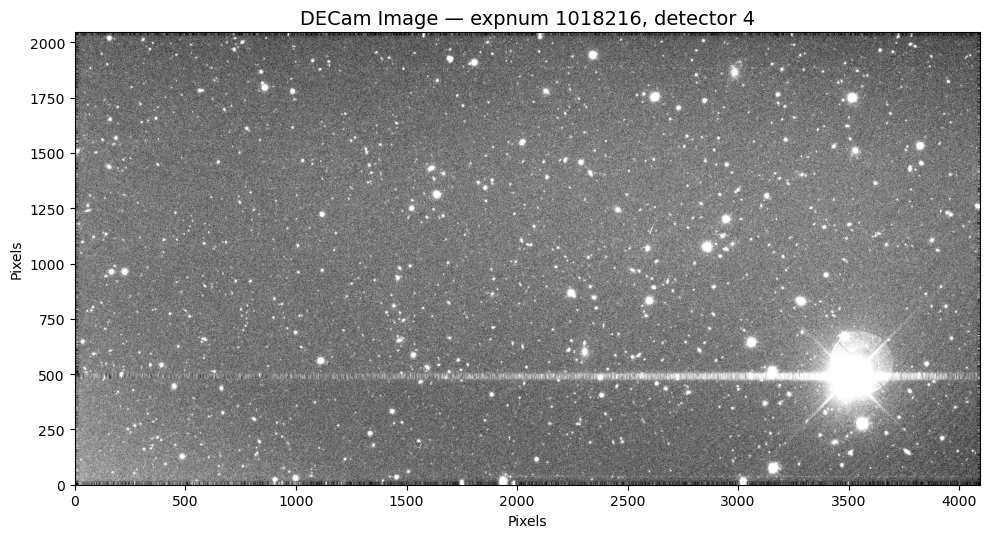

In [8]:
expnum =  1018216 #1138498
detector =  4 #23  

image_data, header, header_expnum = load_decam_image(expnum, detector)

if image_data is not None:
    plot_decam_image(image_data, expnum=expnum, detector=detector)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0 255   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 255   0]]


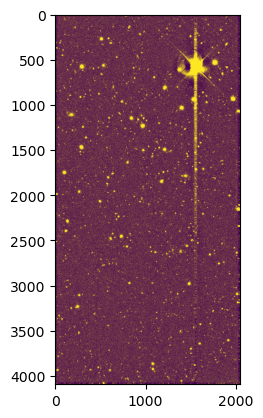

In [9]:
detected_lines= detect_lines_hough(image_data)
                                 #  brightness_cuts, thresholding_cut) 
                                   #flux_prop_thresholds=[0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1.0],
                                   #blur_kernel_sizes= [2, 3, 4, 5, 9, 11, 15, 17])
plt.imshow(detected_lines['Thresholded Image'])
print(detected_lines['Thresholded Image'])

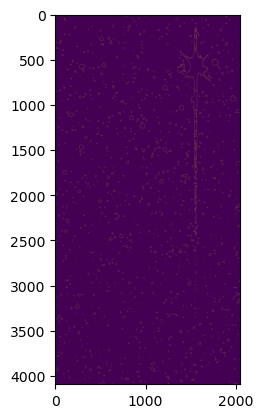

In [10]:
plt.imshow(detected_lines['Edges'])

In [11]:
clustered_lines = ld.cluster(detected_lines["Cartesian Coordinates"], detected_lines["Lines"])

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
print(detected_lines.keys())
for k, v in detected_lines.items():
    print(k, len(v))

In [ ]:
rotated_images, best_fit_params = ir.complete_rotate_image(
                                                clustered_lines=clustered_lines,
                                                angles=detected_lines["Angles"],
                                                image=image_data,
                                                cart_coord=detected_lines['Cartesian Coordinates'])

In [ ]:
print(rotated_images)
print(best_fit_params)


In [ ]:
pixelplot.pixelplot(rotated_images[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Load image ---
image_data = rotated_images[0]

# --- Step 1: Mask bright sources ---
median = np.median(image_data)
std = np.std(image_data)
threshold = median + 3 * std
mask = image_data > threshold
masked_data = np.ma.array(image_data, mask=mask)

# --- Step 2: Collapse image to 1D profile across y ---
profile_y = np.ma.mean(masked_data, axis=1)
y = np.arange(len(profile_y))

# --- Step 3: Fit a 1D Gaussian to the profile ---
def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

# Initial guesses
A0 = profile_y.max()
y0 = y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]

popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 4: Define on-streak and off-streak regions ---
on_ymin = int(y0_fit - 3 * sigma_fit)
on_ymax = int(y0_fit + 3 * sigma_fit)
height = on_ymax - on_ymin

off1_ymin = max(0, on_ymin - height)
off1_ymax = on_ymin
off2_ymin = on_ymax
off2_ymax = min(image_data.shape[0], on_ymax + height)

# --- Create region masks for visualization ---
region_mask = np.zeros_like(image_data, dtype=int)
region_mask[on_ymin:on_ymax, :] = 1  # on-streak
region_mask[off1_ymin:off1_ymax, :] = 2  # off-streak below
region_mask[off2_ymin:off2_ymax, :] = 2  # off-streak above

# --- Step 5: Extract pixel values ---
on_region = masked_data[on_ymin:on_ymax, :]
off1_region = masked_data[off1_ymin:off1_ymax, :]
off2_region = masked_data[off2_ymin:off2_ymax, :]

on_sum = on_region.sum()
on_unmasked = np.sum(~on_region.mask)

# --- Step 6: Estimate background ---
off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
off_sum = off1_region.sum() + off2_region.sum()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked

# --- Step 7: Compute final flux and surface brightness ---
streak_flux = on_sum - empirical_bkg
pixel_scale = 0.27  # arcsec/pixel (DECam)
sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / (pixel_scale ** 2)

# --- Print results ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Signal sum (masked): {on_sum:.2f}")
print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
print(f"Empirical background: {empirical_bkg:.2f}")
print(f"Streak flux (signal - background): {streak_flux:.2f}")
print(f"Surface brightness: {sb_pixel:.2f} counts/pixel²")
print(f"Surface brightness: {sb_arcsec:.2f} counts/arcsec²")

# --- Plot 1: Masked pixels ---
plt.figure(figsize=(10, 6))
plt.imshow(mask, origin='lower', cmap='gray')
plt.title("Masked Pixels (bright sources)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Mask (True = masked)')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 2: Region overlay on original image ---
plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
           origin='lower', cmap='coolwarm', alpha=0.5)
plt.title("Streak and Background Regions")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 3: 1D profile with region markers ---
plt.figure(figsize=(10, 5))
plt.plot(y, profile_y, label="1D Profile (masked)", color='black')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean Counts")
plt.title("Streak Profile and Regions")
plt.grid(True)
plt.tight_layout()
plt.show()


=== Aperture Photometry Result ===
Streak center (y0): 97.79 px
Width: σ = 12.12 px, FWHM ≈ 28.54 px
On-streak region: y = [61, 134], 148800 unmasked pixels
Streak flux: 4714495.64
Surface brightness: 434.62 ± 0.85 counts/arcsec² [background-dominated]

=== Aperture Photometry Result ===
Streak center (y0): 97.79 px
Width: σ = 12.12 px, FWHM ≈ 28.54 px
On-streak region: y = [61, 134], 148800 unmasked pixels
Off-streak regions: y = [0, 61] and [134, 200]
Signal sum (masked): 484864417.71
Background level: 3226.81 counts/pixel
Empirical background: 480149922.07
Streak flux (signal - background): 4714495.64
Noise regime: background-dominated
Surface brightness: 31.68 ± 0.06 counts/pixel²
Surface brightness: 434.62 ± 0.85 counts/arcsec²


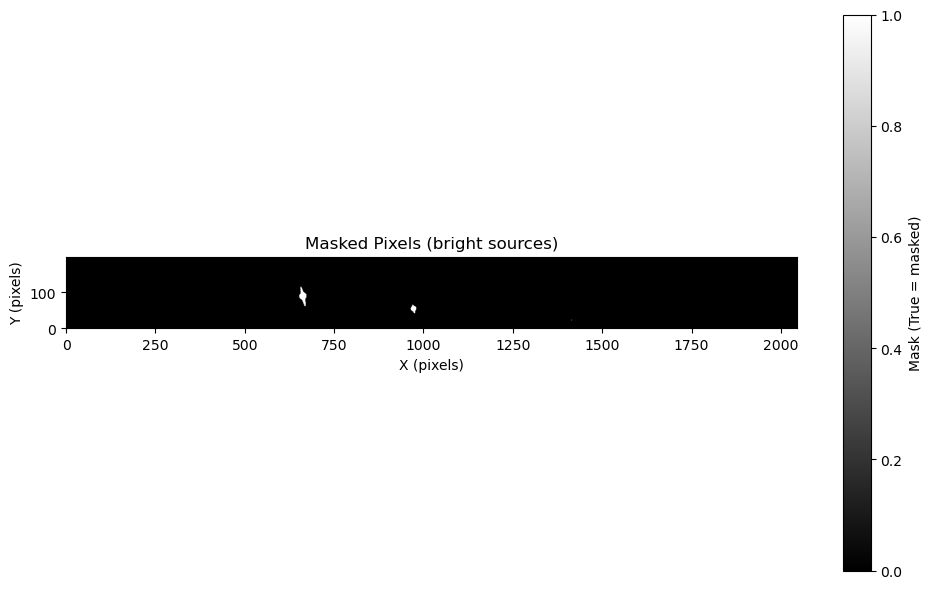

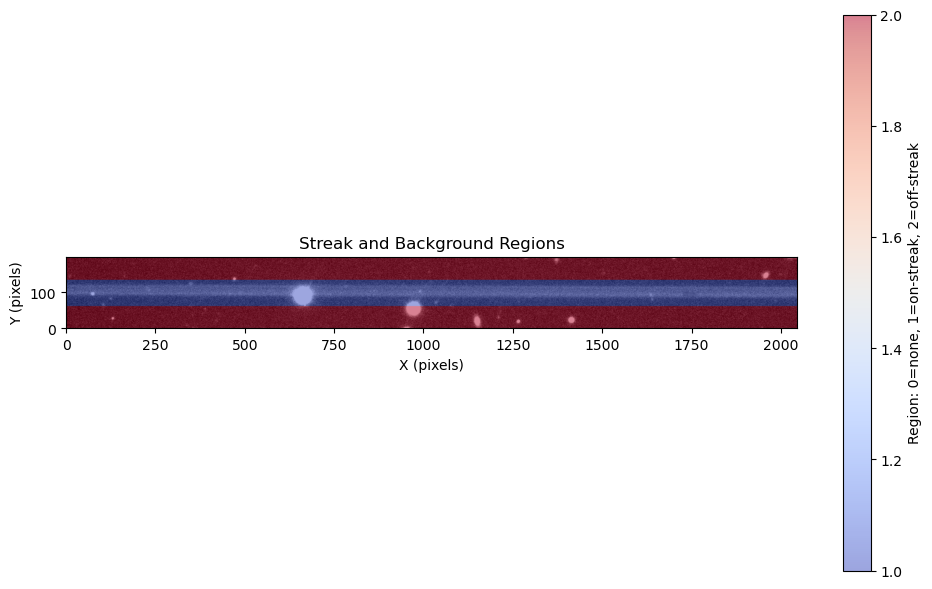

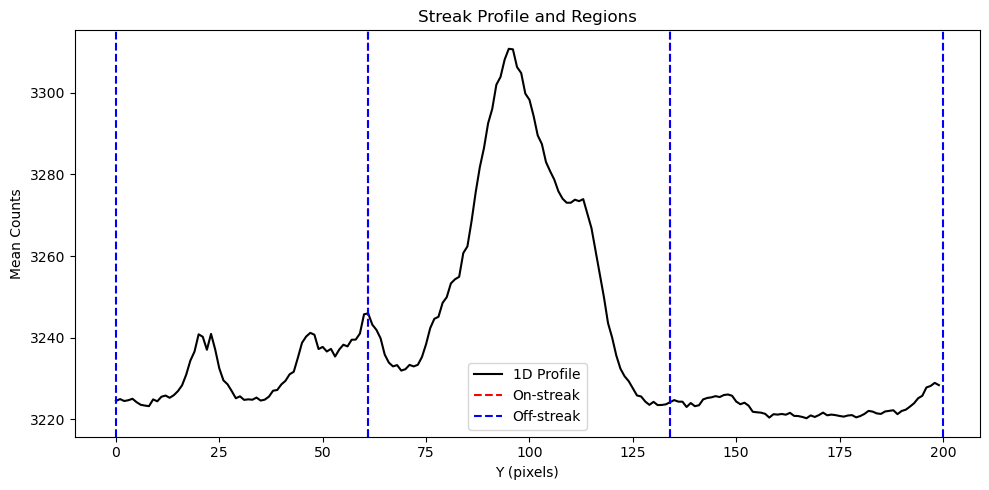

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits

# --- Load image ---
image_data  

# Simulated FITS header
header = {
    "GAINA": 3.77,
    "GAINB": 3.74,
    "RDNOISEA": 5.92,
    "RDNOISEB": 5.87
}

gain = 0.5 * (header["GAINA"] + header["GAINB"])
read_noise = 0.5 * (header["RDNOISEA"] + header["RDNOISEB"])

# --- Step 1: Mask bright sources ---
median = np.median(image_data)
std = np.std(image_data)
threshold = median + 3 * std
mask = image_data > threshold
masked_data = np.ma.array(image_data, mask=mask)

# --- Step 2: Collapse image to 1D profile across y ---
profile_y = np.ma.mean(masked_data, axis=1)
y = np.arange(len(profile_y))

# --- Step 3: Fit a 1D Gaussian to the profile ---
def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

A0 = profile_y.max()
y0 = y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]
popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 4: Define on-streak and off-streak regions ---
on_ymin = int(y0_fit - 3 * sigma_fit)
on_ymax = int(y0_fit + 3 * sigma_fit)
height = on_ymax - on_ymin

off1_ymin = max(0, on_ymin - height)
off1_ymax = on_ymin
off2_ymin = on_ymax
off2_ymax = min(image_data.shape[0], on_ymax + height)

region_mask = np.zeros_like(image_data, dtype=int)
region_mask[on_ymin:on_ymax, :] = 1
region_mask[off1_ymin:off1_ymax, :] = 2
region_mask[off2_ymin:off2_ymax, :] = 2

# --- Step 5: Extract pixel values ---
on_region = masked_data[on_ymin:on_ymax, :]
off1_region = masked_data[off1_ymin:off1_ymax, :]
off2_region = masked_data[off2_ymin:off2_ymax, :]

on_sum = on_region.sum()
on_unmasked = np.sum(~on_region.mask)

# --- Step 6: Estimate background ---
off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
off_sum = off1_region.sum() + off2_region.sum()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked

# --- Step 7: Final flux and surface brightness ---
streak_flux = on_sum - empirical_bkg
pixel_scale = 0.27
sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / (pixel_scale ** 2)

# --- Step 8: Error estimation ---
def estimate_flux_uncertainty(streak_flux, on_unmasked, bkg_std, gain, read_noise):
    flux_e = gain * streak_flux
    signal_per_pixel = flux_e / on_unmasked
    noise_background = on_unmasked * (bkg_std**2 + read_noise**2)
    if signal_per_pixel < 5 * bkg_std:
        regime = "background-dominated"
        flux_var = noise_background
    else:
        regime = "source-dominated"
        flux_var = flux_e + noise_background
    flux_err = np.sqrt(flux_var) / gain  # back to ADU
    return flux_err, regime

off_vals = np.hstack([
    off1_region[~off1_region.mask].ravel(),
    off2_region[~off2_region.mask].ravel()
])
bkg_std = np.std(off_vals)

flux_err, regime = estimate_flux_uncertainty(streak_flux, on_unmasked, bkg_std, gain, read_noise)
sb_pixel_err = flux_err / on_unmasked
sb_arcsec_err = sb_pixel_err / pixel_scale**2

# --- Output ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Streak flux: {streak_flux:.2f}")
print(f"Surface brightness: {sb_arcsec:.2f} ± {sb_arcsec_err:.2f} counts/arcsec² [{regime}]")


# --- Final Output Summary ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Signal sum (masked): {on_sum:.2f}")
print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
print(f"Empirical background: {empirical_bkg:.2f}")
print(f"Streak flux (signal - background): {streak_flux:.2f}")
print(f"Noise regime: {regime}")

print(f"Surface brightness: {sb_pixel:.2f} ± {sb_pixel_err:.2f} counts/pixel²")
print(f"Surface brightness: {sb_arcsec:.2f} ± {sb_arcsec_err:.2f} counts/arcsec²")


# --- Plots ---
plt.figure(figsize=(10, 6))
plt.imshow(mask, origin='lower', cmap='gray')
plt.title("Masked Pixels (bright sources)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Mask (True = masked)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
           origin='lower', cmap='coolwarm', alpha=0.5)
plt.title("Streak and Background Regions")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y, profile_y, label="1D Profile", color='black')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean Counts")
plt.title("Streak Profile and Regions")
plt.tight_layout()
plt.show()

In [172]:
# --- Step 9: Convert to mag/arcsec² using MAGZERO ---
zeropoint = header_expnum['MAGZERO']  # from header['MAGZERO']

# Surface brightness in mag/arcsec²
sb_mag_arcsec2 = -2.5 * np.log10(sb_arcsec) + zeropoint

# Error propagation
sb_mag_arcsec2_err = 1.0857 * (sb_arcsec_err / sb_arcsec)  # this part may be wrong

# Output
print(f"Surface brightness: {sb_mag_arcsec2:.3f} ± {sb_mag_arcsec2_err:.3f} mag/arcsec²")

        #print(f"Surface brightness: {sb_mag_arcsec2:.5f} ± {sb_mag_arcsec2_err:.5f} mag/arcsec²")

Surface brightness: 24.411 ± 0.002 mag/arcsec²
